In [1]:
%pip install torch torchvision transformers diffusers datasets accelerate
!unzip dataset.zip

"unzip" non � riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [2]:
from transformers import AutoImageProcessor, Dinov2ForImageClassification
from diffusers import DiffusionPipeline
import torch
from diffusers import DPMSolverMultistepScheduler
import requests
import torchvision.transforms as transforms
from PIL import Image
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt

C:\Users\tomma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
discriminator_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")
discriminator_model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-small")

discriminator_model.classifier = torch.nn.Sequential(
    torch.nn.Flatten(),  # Flatten the output
    torch.nn.Linear(768, 256),  # Adjust the input features to match flattened output
    torch.nn.ReLU(),
    #torch.nn.functional.Normalize(),  # Batch normalization layer
    #torch.nn.BatchNorm1d(256),
    torch.nn.LayerNorm(256),
    torch.nn.Linear(256, 1),
    # torch.nn.Hardtanh()
    torch.nn.Sigmoid()
)


Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-small and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
teacher_model = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1", safety_checker=None, torch_dtype=torch.float16)
teacher_model.scheduler = DPMSolverMultistepScheduler.from_config(teacher_model.scheduler.config)
#teacher_model.safety_checker = lambda image : False

student_model = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",safety_checker=None, torch_dtype=torch.float16)
student_model.scheduler = DPMSolverMultistepScheduler.from_config(student_model.scheduler.config)

Loading pipeline components...: 100%|██████████| 6/6 [00:09<00:00,  1.59s/it]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [6]:
# Move models to the chosen device

# discriminator_model = discriminator_model.to(device)
student_model = student_model.to(device)
teacher_model = teacher_model.to(device)
print(discriminator_model)


Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2Attention(
            (attention): Dinov2SelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
       

In [7]:
# Set up the loss functions for the student model

# def adversarial_loss_function(y_pred, y_true):
#     return torch.nn.functional.relu(1 - y_pred * y_true)

# def student_loss_function(y_pred, y_true):
#     return - y_pred * y_true

# # Hinge loss for adversarial loss
# adversarial_loss_function.requires_gradient = True

# MSE loss for distillation loss

adversarial_loss_function = torch.nn.BCELoss()

distillation_loss_function = torch.nn.MSELoss()
distillation_loss_function.requires_gradient = True

# Set up the optimizer for the student model
student_optimizer = torch.optim.Adam(student_model.unet.parameters(), lr=0.1)

# Assuming you have a discriminator model defined
discriminator_model_optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=0.000001)

In [8]:
# load the train dataset from folder dataset/captions_train2017.json
dataset = load_dataset('json', data_files='dataset/dataset.json')

train_dataset = dataset["train"]

#split the dataset into train and validation
dataset = train_dataset.train_test_split(test_size=0.1)

train_dataset = dataset["train"]
validation_dataset = dataset["test"]

#further split the train dataset into train and validation
dataset = train_dataset.train_test_split(test_size=0.1)

train_dataset = dataset["train"]
test_dataset = dataset["test"]

print(train_dataset)
print(validation_dataset)
print(test_dataset)

torch.set_grad_enabled(True)
torch.autograd.set_detect_anomaly(True)


Dataset({
    features: ['caption', 'image'],
    num_rows: 239659
})
Dataset({
    features: ['caption', 'image'],
    num_rows: 29588
})
Dataset({
    features: ['caption', 'image'],
    num_rows: 26629
})


In [9]:
# Function to convert an image from a URL to a PyTorch Tensor
def url_to_tensor(url):

    img = Image.open(requests.get(url, stream=True).raw)

    # Define a transform to convert the image to tensor
    transform = transforms.Compose([
        transforms.Resize((768, 768)),  # Resize the image
        transforms.ToTensor()           # Convert the image to a PyTorch Tensor
    ])

    # Apply the transform to the image
    img_tensor = transform(img)

    return img_tensor

# Get the first image in the training dataset
img_tensor = url_to_tensor(train_dataset[0]['image'])

# Print the shape of the image tensor
print(img_tensor.shape)

torch.Size([3, 768, 768])


In [10]:
def show_tensor_image(pic):

    # Convert the tensor to a PIL Image
    if (isinstance(pic, torch.Tensor)):
        pil_image = transforms.ToPILImage()(pic)

    else:
        pil_image = pic

    # Display the image
    plt.imshow(pil_image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

def forward_noise(image, a, s, num_diffusion_steps):

    if (not isinstance(image, torch.Tensor)):
        transform = transforms.ToTensor()
        image = transform(image)

    for i in range(num_diffusion_steps):
        noise = np.random.normal(size=image.shape)  # noise mask
        image = image * a + noise * s

    return image

Epoch 0, Batch Caption: there is a man standing in the desert next to a bike


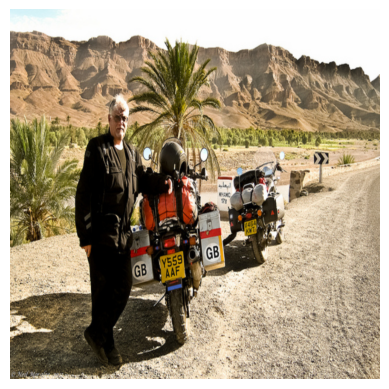

Performing forward diffusion...
Generating student image...


100%|██████████| 4/4 [00:13<00:00,  3.36s/it]


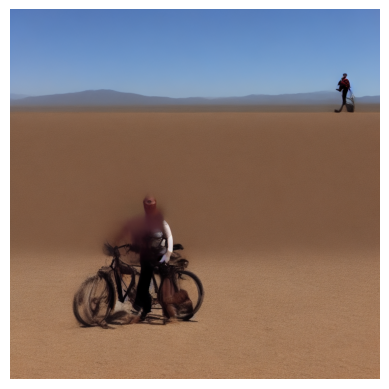

Forward diffusion on student image...
Generating teacher image...


100%|██████████| 100/100 [05:38<00:00,  3.39s/it]


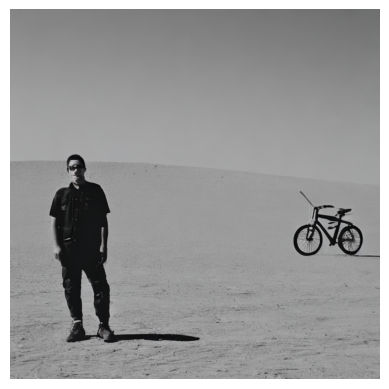

real pred = (tensor([[0.7304]], grad_fn=<SigmoidBackward0>),)
real_pred[0][0][0] = 0.7303934097290039]
Discriminator real Loss: 0.3141719698905945
student pred = (tensor([[0.6753]], grad_fn=<SigmoidBackward0>),)
student_pred[0][0][0] = 0.6752616763114929
Discriminator Fake Loss: 1.1247355937957764
Student Loss: 0.39265498518943787
Adversarial Loss: 0.7194538116455078
Distillation Loss: 0.9352245330810547
End of batch processing.

Epoch 0, Batch Caption: A table has a fan with knives and scissors hanging near it.


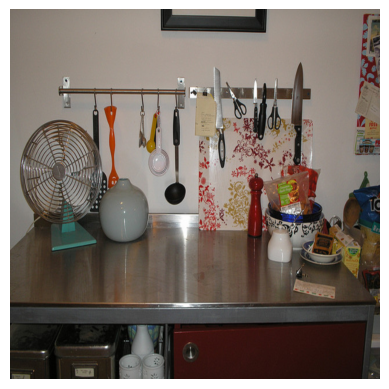

Performing forward diffusion...
Generating student image...


100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


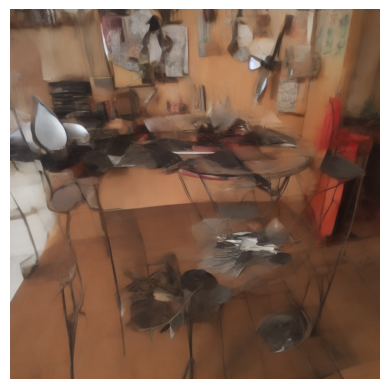

Forward diffusion on student image...
Generating teacher image...


100%|██████████| 100/100 [05:33<00:00,  3.33s/it]


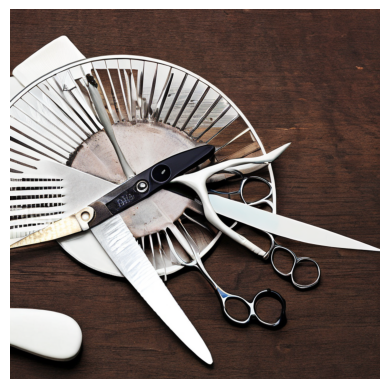

real pred = (tensor([[0.7613]], grad_fn=<SigmoidBackward0>),)
real_pred[0][0][0] = 0.7612839937210083]
Discriminator real Loss: 0.27274879813194275
student pred = (tensor([[0.6476]], grad_fn=<SigmoidBackward0>),)
student_pred[0][0][0] = 0.6476160287857056
Discriminator Fake Loss: 1.0430338382720947
Student Loss: 0.43445730209350586
Adversarial Loss: 0.6578913331031799
Distillation Loss: 0.7081046104431152
End of batch processing.

Epoch 0, Batch Caption: A man skieing down a hill with no poles.


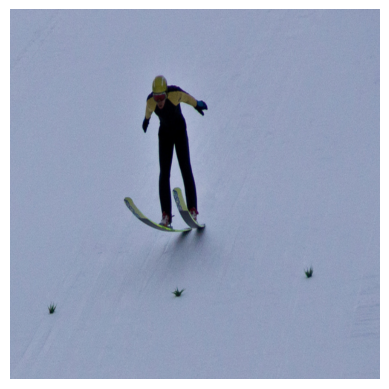

Performing forward diffusion...
Generating student image...


100%|██████████| 4/4 [00:12<00:00,  3.08s/it]


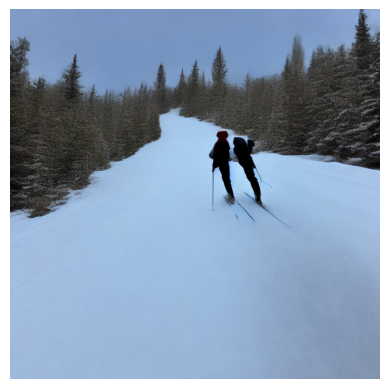

Forward diffusion on student image...
Generating teacher image...


 11%|█         | 11/100 [00:41<05:36,  3.78s/it]


KeyboardInterrupt: 

In [12]:
for epoch in range(100):
    for batch in train_dataset:

        image = url_to_tensor(batch["image"])
        caption = batch["caption"]

        # Creating labels for real and fake images
        valid = torch.ones(image.size(0), 1)
        fake = torch.zeros(image.size(0), 1)
        real_image = image

        # Displaying the base image and its caption
        print(f"Epoch {epoch}, Batch Caption: {caption}")
        show_tensor_image(real_image)

        # Forward diffusion step
        print("Performing forward diffusion...")
        diffused_image = forward_noise(image, a=0.5, s=0.5, num_diffusion_steps=50)

        # Transforming images for distillation loss calculation
        transform = transforms.ToTensor()

        # Generating student image
        print("Generating student image...")
        student_image = student_model(caption, image=diffused_image, height=768, width=768, num_inference_steps=4).images[0]
        student_image_tensor = transform(student_image)
        show_tensor_image(student_image_tensor)

        # Forward diffusion on student image
        print("Forward diffusion on student image...")
        new_diffused_image = forward_noise(student_image, a=0.5, s=0.5, num_diffusion_steps=50)

        # Generating teacher image
        print("Generating teacher image...")
        teacher_image = teacher_model(caption, image=new_diffused_image, height=768, width=768, num_inference_steps=100).images[0]
        teacher_image_tensor = transform(teacher_image)
        show_tensor_image(teacher_image_tensor)

        # Discriminator predictions and loss for real image
        real_pred = discriminator_processor(image, return_tensors="pt")
        real_pred = discriminator_model(**real_pred, return_dict=False)

        print(f"real pred = {real_pred}")
        print(f"real_pred[0][0][0] = {real_pred[0][0][0]}]")


        discriminator_real_loss = adversarial_loss_function(real_pred[0][0][0], torch.tensor(1.))

        print(f"Discriminator real Loss: {discriminator_real_loss}")

        # Discriminator predictions and loss for student image
        student_pred = discriminator_processor(student_image, return_tensors="pt")
        student_pred = discriminator_model(**student_pred, return_dict=False)

        print(f"student pred = {student_pred}")
        print(f"student_pred[0][0][0] = {student_pred[0][0][0]}")

        discriminator_fake_loss = adversarial_loss_function(student_pred[0][0][0], torch.tensor(0.))
        
        #student_loss = adversarial_loss_function(student_pred[0][0], torch.tensor(1.))
        student_loss = adversarial_loss_function(student_pred[0][0][0], torch.tensor(1.))

        print(f"Discriminator Fake Loss: {discriminator_fake_loss}")
        print(f"Student Loss: {student_loss}")

        # Calculating adversarial loss
        adversarial_loss = (discriminator_real_loss + discriminator_fake_loss)/2
        print(f"Adversarial Loss: {adversarial_loss}")

        # Computing distillation loss
        distillation_loss = distillation_loss_function(student_image_tensor, teacher_image_tensor)
        distillation_loss.requires_grad = True
        print(f"Distillation Loss: {distillation_loss}")

        # Backpropagation for student model
        student_optimizer.zero_grad()
        student_loss.backward(retain_graph=True) # Retain graph because student model also needs to backpropagate in this iteration
        distillation_loss.backward()
        student_optimizer.step()

        # Backpropagation for discriminator model
        discriminator_model_optimizer.zero_grad()
        adversarial_loss.backward()
        discriminator_model_optimizer.step()

        print("End of batch processing.\n")
